In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('max_columns', None)
sns.set_theme(palette=sns.color_palette("Set2"), rc={'figure.figsize':(12,6)})

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, KFold, RandomizedSearchCV, GridSearchCV

# EDA

In [3]:
action_train = pd.read_csv('../input/internshipsbertask/Task/action_train.csv', index_col=0, parse_dates=['date'])
action_test = pd.read_csv('../input/internshipsbertask/Task/action_test.csv', index_col=0, parse_dates=['date'])
person = pd.read_csv('../input/internshipsbertask/Task/person.csv', index_col=0)
action_id = action_test.action_id

print(action_train.shape)
print(action_test.shape)
print(person.shape)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2197291, 15)
(498687, 14)
(189118, 41)


In [4]:
action_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2197291 entries, 0 to 2197290
Data columns (total 15 columns):
 #   Column       Dtype         
---  ------       -----         
 0   person_id    object        
 1   action_id    object        
 2   date         datetime64[ns]
 3   action_type  object        
 4   char_1       object        
 5   char_2       object        
 6   char_3       object        
 7   char_4       object        
 8   char_5       object        
 9   char_6       object        
 10  char_7       object        
 11  char_8       object        
 12  char_9       object        
 13  char_10      object        
 14  result       int64         
dtypes: datetime64[ns](1), int64(1), object(13)
memory usage: 268.2+ MB


In [5]:
person.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189118 entries, 0 to 189117
Data columns (total 41 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   person_id  189118 non-null  object
 1   char_1     189118 non-null  object
 2   group_1    189118 non-null  object
 3   char_2     189118 non-null  object
 4   date       189118 non-null  object
 5   char_3     189118 non-null  object
 6   char_4     189118 non-null  object
 7   char_5     189118 non-null  object
 8   char_6     189118 non-null  object
 9   char_7     189118 non-null  object
 10  char_8     189118 non-null  object
 11  char_9     189118 non-null  object
 12  char_10    189118 non-null  bool  
 13  char_11    189118 non-null  bool  
 14  char_12    189118 non-null  bool  
 15  char_13    189118 non-null  bool  
 16  char_14    189118 non-null  bool  
 17  char_15    189118 non-null  bool  
 18  char_16    189118 non-null  bool  
 19  char_17    189118 non-null  bool  
 20  char

<font size=4> Так как признаки у нас только категориальные(кроме даты и char_38). То я объединю трейн и тест для совместной обработки, не переживая за утечку данных. Char_38 обработаем отдельно.

In [6]:
action_train.head(3)

,person_id,action_id,date,action_type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,result
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [7]:
action_test.head(3)

,person_id,action_id,date,action_type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN
1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 682
2,ppl_10001,act1_240724,2022-10-14,type 1,type 12,type 1,type 5,type 4,type 6,type 1,type 1,type 13,type 10,NaN


In [8]:
person.head(3)

,person_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,type 2,type 4,False,False,True,True,False,False,False,True,False,False,False,False,False,True,False,True,True,True,False,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,type 2,type 2,True,True,True,True,True,True,False,True,False,True,False,True,True,True,True,True,True,True,True,False,False,True,True,True,True,False,True,True,99


In [9]:
train = action_train.join(person.set_index('person_id'), on='person_id', lsuffix='_action')
test = action_test.join(person.set_index('person_id'), on='person_id', lsuffix='_action')

In [10]:
train[action_train.action_type == 'type 1'].head()

,person_id,action_id,date_action,action_type,char_1_action,char_2_action,char_3_action,char_4_action,char_5_action,char_6_action,char_7_action,char_8_action,char_9_action,char_10_action,result,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
52,ppl_100025,act1_9923,2022-11-25,type 1,type 3,type 5,type 1,type 1,type 6,type 3,type 3,type 6,type 8,NaN,0,type 2,group 36096,type 3,2022-08-26,type 14,type 6,type 8,type 3,type 9,type 6,type 6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,76
105,ppl_100033,act1_198174,2022-07-26,type 1,type 36,type 11,type 5,type 1,type 6,type 1,type 1,type 4,type 1,NaN,0,type 2,group 17304,type 2,2022-07-26,type 10,type 7,type 6,type 3,type 9,type 3,type 3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0
106,ppl_100033,act1_214090,2023-06-15,type 1,type 24,type 6,type 6,type 3,type 1,type 3,type 4,type 5,type 1,NaN,0,type 2,group 17304,type 2,2022-07-26,type 10,type 7,type 6,type 3,type 9,type 3,type 3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0
107,ppl_100033,act1_230588,2023-02-28,type 1,type 2,type 2,type 3,type 3,type 5,type 2,type 2,type 4,type 2,NaN,0,type 2,group 17304,type 2,2022-07-26,type 10,type 7,type 6,type 3,type 9,type 3,type 3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0
108,ppl_100033,act1_271874,2022-07-26,type 1,type 2,type 5,type 3,type 2,type 6,type 1,type 1,type 6,type 8,NaN,0,type 2,group 17304,type 2,2022-07-26,type 10,type 7,type 6,type 3,type 9,type 3,type 3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0


## action_type

данный признак является одним из определяющих, поэтому изучим его подробнее

In [11]:
train.action_type.value_counts()

type 2    904683
type 5    490710
type 3    429408
type 4    207465
type 1    157615
type 6      4253
type 7      3157
Name: action_type, dtype: int64

In [12]:
test.action_type.value_counts()

type 2    223164
type 5    123463
type 3     59931
type 4     50215
type 1     40092
type 6      1051
type 7       771
Name: action_type, dtype: int64

заметим, что признаков типа 5 и 6 крайне мало, по сравнению с остальными

<AxesSubplot:xlabel='action_type', ylabel='result'>

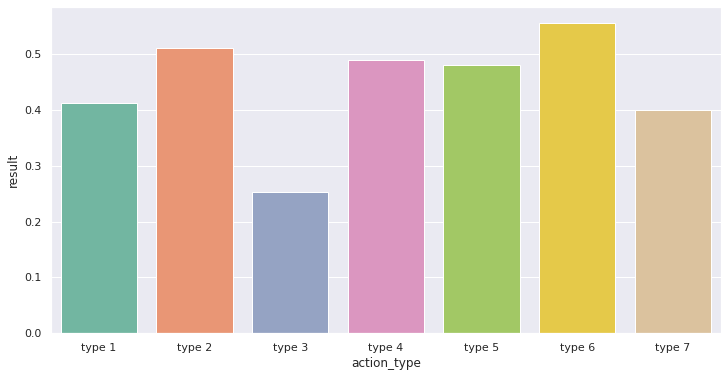

In [13]:
order = ['type ' + str(i) for i in range(1, 8)]
sns.barplot(data=train, y='result', x='action_type', order=order, ci=None)

## date

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2197291 entries, 0 to 2197290
Data columns (total 55 columns):
 #   Column          Dtype         
---  ------          -----         
 0   person_id       object        
 1   action_id       object        
 2   date_action     datetime64[ns]
 3   action_type     object        
 4   char_1_action   object        
 5   char_2_action   object        
 6   char_3_action   object        
 7   char_4_action   object        
 8   char_5_action   object        
 9   char_6_action   object        
 10  char_7_action   object        
 11  char_8_action   object        
 12  char_9_action   object        
 13  char_10_action  object        
 14  result          int64         
 15  char_1          object        
 16  group_1         object        
 17  char_2          object        
 18  date            object        
 19  char_3          object        
 20  char_4          object        
 21  char_5          object        
 22  char_6          ob

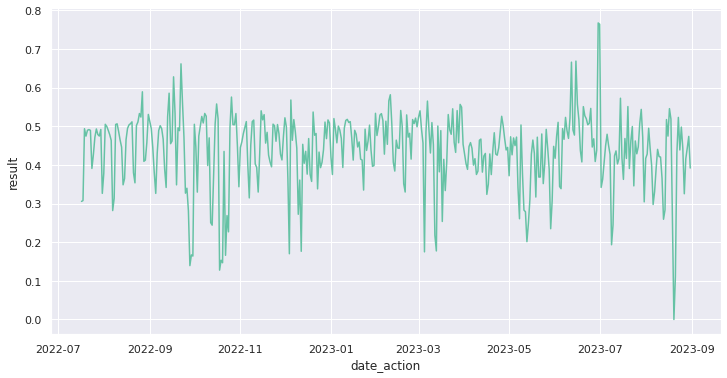

In [15]:
sns.lineplot(data=train.groupby(['date_action'])['result'].mean().reset_index(), x='date_action', y='result');

In [16]:
def plot_seasonality(df, x_axis):
    
    df = df.copy()
    
    df['month'] = df['date_action'].dt.month
    df['day_of_week'] = df['date_action'].dt.dayofweek
    df['day_of_year'] = df['date_action'].dt.dayofyear
    
    
    fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    sns.lineplot(data=df.groupby([x_axis])['result'].mean().reset_index(), x=x_axis, y='result', ax=axes)
    axes.set_title(f'{x_axis} Seasonality for all years')

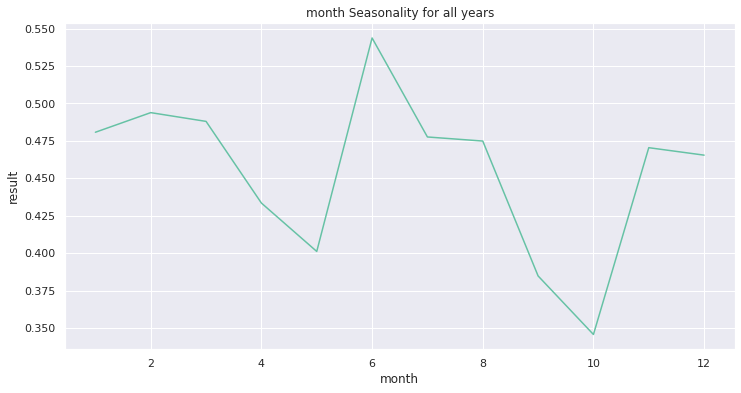

In [17]:
plot_seasonality(train[['date_action', 'result']], 'month')

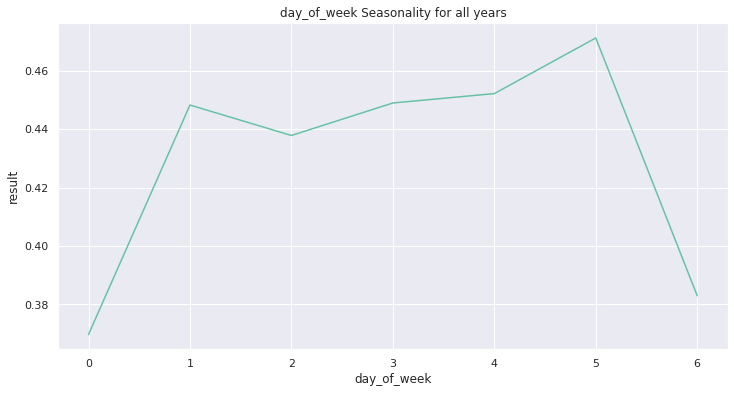

In [18]:
plot_seasonality(train[['date_action', 'result']], 'day_of_week')

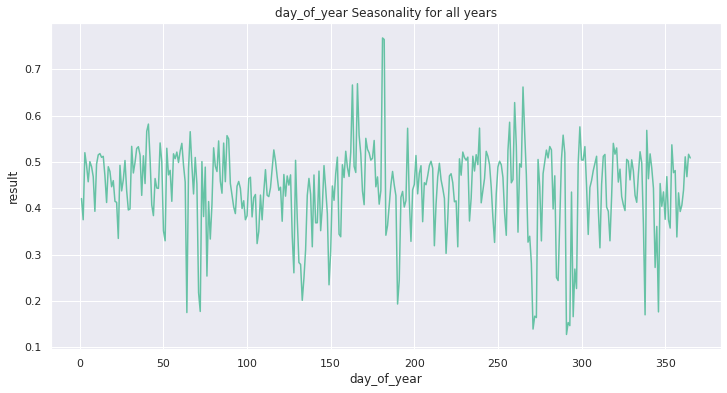

In [19]:
plot_seasonality(train[['date_action', 'result']], 'day_of_year')

<font size=4> Можем увидеть, что и день, и месяц имеют большое значение в результате

In [20]:
print('train min date: ', action_train['date'].min())
print('train max date: ', action_train['date'].max())
print('test min date: ', action_test['date'].min())
print('test max date: ', action_test['date'].max())

train min date:  2022-07-17 00:00:00
train max date:  2023-08-31 00:00:00
test min date:  2022-07-17 00:00:00
test max date:  2023-08-31 00:00:00


# Filling missing values



In [21]:
y_train = train.result
joined_df = pd.concat([train.drop(columns='result'), test])

In [22]:
print(train.shape)
print(test.shape)
print(joined_df.shape)

(2197291, 55)
(498687, 54)
(2695978, 54)


In [23]:
def count_na(df):
    return df.isna().sum()[df.isna().sum() != 0]

In [24]:
def count_unique(df, min_freq):
    total = 0
    for col in df.columns:
        total += len(df[col].unique())
        if len(df[col].unique()) >= min_freq:
            print(col, len(df[col].unique()))
    print(f'total_unique = {total}')

In [25]:
count_na(joined_df)

char_1_action     2498271
char_2_action     2498271
char_3_action     2498271
char_4_action     2498271
char_5_action     2498271
char_6_action     2498271
char_7_action     2498271
char_8_action     2498271
char_9_action     2498271
char_10_action     197707
dtype: int64

In [26]:
for i in range(1, 11):
    column = 'char_' + str(i) + '_action'
    joined_df[column].fillna('type -1', inplace=True)

In [27]:
count_na(joined_df)

Series([], dtype: int64)

# Feature Engineering

In [28]:
count_unique(joined_df, min_freq=3)

person_id 189118
action_id 2695978
date_action 411
action_type 7
char_1_action 52
char_2_action 33
char_3_action 12
char_4_action 8
char_5_action 8
char_6_action 6
char_7_action 9
char_8_action 19
char_9_action 20
char_10_action 6970
group_1 34224
char_2 3
date 1196
char_3 43
char_4 25
char_5 9
char_6 7
char_7 25
char_8 8
char_9 9
char_38 101
total_unique = 2928359


* Я собираюсь кодировать признаки с помощью One-Hot кодирования, так как в отсутствии дополнительной информации мы не можем предположить, что значения признаков являются упорядоченными.

* Так как char_10_action - очень важная характеристика (только ей обладают действия типа 2-7), мы соберём редкие характеристики в новый тип type_rare. Так же поступим для нескольких других признаков

* Group_1, как id, мы удалим, потому что они обладают слишком большим количеством значений для кодирования. И, на первый взгляд, не представляют особой важности.

In [29]:
def unite_rares(df, column, limit):
    freqs = df[column].value_counts()
    rare_types = set([col_type for col_type in freqs.index if freqs[col_type] <= limit])

    df[column] = df[column].apply(lambda x: 'type_rare' if x in rare_types else x)
    del freqs, rare_types
    return df

## char_10_action

In [30]:
(joined_df.char_10_action.value_counts() <= 5000).sum()

6941

In [31]:
joined_df = unite_rares(joined_df, 'char_10_action', 5000)

## char_1_action

In [32]:
(joined_df.char_1_action.value_counts() <= 1000).sum()

31

In [33]:
joined_df = unite_rares(joined_df, 'char_1_action', 1000)

## char_2_action

In [34]:
(joined_df.char_2_action.value_counts() <= 1000).sum()

16

In [35]:
joined_df = unite_rares(joined_df, 'char_2_action', 1000)

## char_9_action

In [36]:
(joined_df.char_9_action.value_counts() <= 6000).sum()

6

In [37]:
joined_df = unite_rares(joined_df, 'char_9_action', 6000)

## char_3

In [38]:
(joined_df.char_3.value_counts() <= 10000).sum()

22

In [39]:
joined_df = unite_rares(joined_df,'char_3', 10000)

In [40]:
count_unique(joined_df, min_freq=3)

person_id 189118
action_id 2695978
date_action 411
action_type 7
char_1_action 22
char_2_action 18
char_3_action 12
char_4_action 8
char_5_action 8
char_6_action 6
char_7_action 9
char_8_action 19
char_9_action 15
char_10_action 30
group_1 34224
char_2 3
date 1196
char_3 22
char_4 25
char_5 9
char_6 7
char_7 25
char_8 8
char_9 9
char_38 101
total_unique = 2921348


In [41]:
joined_df['month'] = joined_df['date_action'].dt.month
joined_df['day_of_week'] = joined_df['date_action'].dt.dayofweek
joined_df['day_of_year'] = joined_df['date_action'].dt.dayofyear

In [42]:
joined_df.head(2)

,person_id,action_id,date_action,action_type,char_1_action,char_2_action,char_3_action,char_4_action,char_5_action,char_6_action,char_7_action,char_8_action,char_9_action,char_10_action,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month,day_of_week,day_of_year
0,ppl_100,act2_1734928,2023-08-26,type 4,type -1,type -1,type -1,type -1,type -1,type -1,type -1,type -1,type -1,type_rare,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36,8,5,238
1,ppl_100,act2_2434093,2022-09-27,type 2,type -1,type -1,type -1,type -1,type -1,type -1,type -1,type -1,type -1,type 1,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36,9,1,270


In [43]:
joined_df = pd.get_dummies(joined_df.drop(columns=['person_id', 'action_id', 'date_action', 'date', 'group_1']), drop_first=True)

In [44]:
X_train = joined_df[:train.shape[0]]
X_test = joined_df[train.shape[0]:]

In [45]:
print(X_train.shape, y_train.shape)
print(X_test.shape)

(2197291, 276) (2197291,)
(498687, 276)


In [46]:
for col in X_train.columns:
    if col not in ['char_38','month', 'day_of_week', 'day_of_year']:
        X_train.loc[:, col] = X_train.loc[:, col].astype('uint8')
        X_test.loc[:, col] = X_test.loc[:, col].astype('uint8')

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2197291 entries, 0 to 2197290
Columns: 276 entries, char_10 to char_9_type 9
dtypes: int64(4), uint8(272)
memory usage: 653.8 MB


In [48]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498687 entries, 0 to 498686
Columns: 276 entries, char_10 to char_9_type 9
dtypes: int64(4), uint8(272)
memory usage: 148.4 MB


# Dimensionality reduction

Поскольку для такого большого датасета мне не хватит оперативки, я сожму его до разумных размеров

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)
X_train_embedded = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)
X_test_embedded = pca.fit_transform(X_test)
print(pca.explained_variance_ratio_)

[8.92036130e-01 1.06835626e-01 2.25695612e-04 1.97787043e-04
 6.24062520e-05 4.78673859e-05 2.88025813e-05 2.79911273e-05
 2.49067898e-05 2.42086425e-05 2.12966022e-05 2.01791454e-05
 1.85115656e-05 1.51144349e-05 1.41945358e-05 1.34930070e-05
 1.29921660e-05 1.14045896e-05 1.11839422e-05 1.03883921e-05
 9.80980611e-06 9.48586860e-06 8.92056638e-06 8.27207658e-06
 8.09678721e-06 8.07191190e-06 7.40218215e-06 6.95908686e-06
 6.91268698e-06 6.66342898e-06]
[8.99216106e-01 9.96600828e-02 2.20721568e-04 1.92405492e-04
 5.82494220e-05 5.08480559e-05 2.92379763e-05 2.71566467e-05
 2.53216298e-05 2.20118916e-05 2.08149526e-05 2.01872644e-05
 1.74604962e-05 1.55573463e-05 1.47809444e-05 1.37540166e-05
 1.25885611e-05 1.14228645e-05 1.10828643e-05 1.04454671e-05
 1.03329868e-05 9.39852446e-06 8.99773896e-06 8.53005561e-06
 8.19098398e-06 8.02673382e-06 7.52283280e-06 7.41677011e-06
 7.22830526e-06 6.76372194e-06]


In [50]:
del action_train, action_test, person, pca, X_train, X_test, joined_df, train, test

# Training

In [51]:
def add_stats(df, clf, X, y, name):
    cv_results = cross_validate(clf, X, y, cv=3, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    acc = np.mean(cv_results["test_accuracy"]).round(4)
    prec = np.mean(cv_results["test_precision"]).round(4)
    rec = np.mean(cv_results["test_recall"]).round(4)
    f1 = np.mean(cv_results["test_f1"]).round(4)
    roc_auc = np.mean(cv_results["test_roc_auc"]).round(4)
    df[name] = [acc, prec, rec, f1, roc_auc]
    return df

In [ ]:
from tqdm.notebook import tqdm
classifiers = [RandomForestClassifier(), LogisticRegression(solver='liblinear'), GradientBoostingClassifier()]

names = ['RandomForest','LogisticRegression', 'GradientBoosting']

model_compar_base = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])

for clf, clf_name in tqdm(zip(classifiers, names)):
    model_compar_base = add_stats(model_compar_base, clf, X_train_embedded, y_train,clf_name)
    del clf

Cравним несколько моделей. Данное сравнение я запускал на старой версии обработанного датасета, а когда я переделывал, времени не хватило. Так что я решил показать хотя бы старые результаты.

<AxesSubplot:xlabel='AUC'>

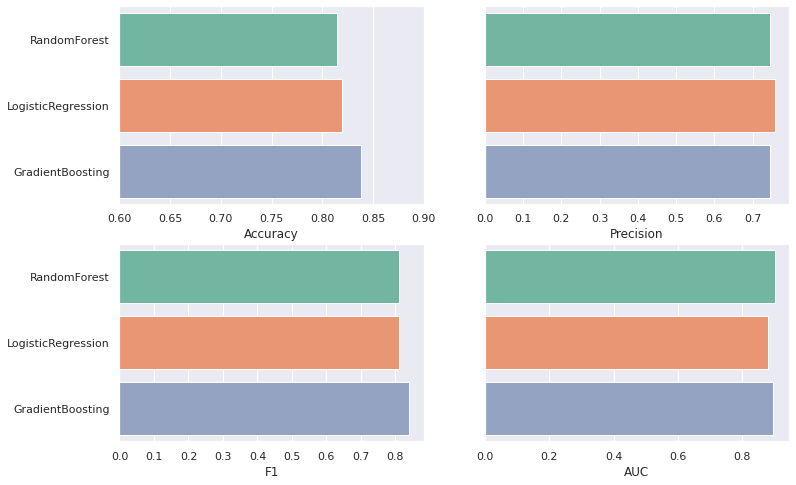

In [47]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 2, sharey=True, figsize=(12, 8))
sns.barplot(data=model_compar_base.T, y=model_compar_base.columns.values, x='Accuracy', orient='horizont', ax=axes[0][0])
axes[0][0].set_xlim(0.6, 0.9)
sns.barplot(data=model_compar_base.T, y=model_compar_base.columns.values, x='Precision', orient='horizont', ax=axes[0][1])
sns.barplot(data=model_compar_base.T, y=model_compar_base.columns.values, x='F1', orient='horizont', ax=axes[1][0])
sns.barplot(data=model_compar_base.T, y=model_compar_base.columns.values, x='AUC', orient='horizont', ax=axes[1][1])

Также стоило бы подтюнить лучшую модель с помощью следующего кода (на примере RandomForest):

In [ ]:
model_compar = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])

TRAIN = False
if TRAIN:
    param_grid = { 
        'n_estimators': [100, 300, 500, 700, 1000],
        'max_features': ['auto', 'log2'],
        'max_depth': [5, 7, 9, 11, 13, 15],
        'criterion': ['gini', 'entropy'],
        'bootstrap': [True, False],
    }

    model = RandomForestClassifier()
    rscv = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=-1,
                              scoring='accuracy', refit=True, verbose=10)
    rscv.fit(X_train, y_train)

    rf_params = rscv.best_params_
    print(rscv.best_params_)
    print(rscv.best_score_)

    model_compar = add_stats(model_compar, rscv.best_estimator_, X_train, y_train, 'RandomForrest')

Но, даже со сжатым датасетом модели обучаются достаточно долго, чтобы обучать их десятки раз. Поэтому я решил взять модель из коробки. Всё-таки это не соревнование, и тут не стоит гнаться за процентами прироста.

In [52]:
X_train_embedded.shape

(2197291, 30)

In [54]:
gb = GradientBoostingClassifier(verbose=3)
gb.fit(X_train_embedded, y_train)
y_pred = gb.predict(X_test_embedded)

      Iter       Train Loss   Remaining Time 
         1           1.2776           51.16m
         2           1.1988           50.77m
         3           1.1334           50.11m
         4           1.0785           49.56m
         5           1.0316           48.99m
         6           0.9910           48.42m
         7           0.9573           47.93m
         8           0.9278           47.46m
         9           0.9026           46.95m
        10           0.8801           46.44m
        11           0.8606           45.93m
        12           0.8437           45.45m
        13           0.8286           44.98m
        14           0.8160           44.50m
        15           0.8053           44.00m
        16           0.7953           43.49m
        17           0.7863           42.95m
        18           0.7781           42.41m
        19           0.7709           41.88m
        20           0.7648           41.36m
        21           0.7593           40.85m
        2

In [55]:
output = pd.DataFrame({'action_id': action_id, 'result': y_pred})
output.to_csv('submission.csv', index=False)

In [56]:
action_train = pd.read_csv('../input/internshipsbertask/Task/action_train.csv', index_col=0, parse_dates=['date'])
action_test = pd.read_csv('../input/internshipsbertask/Task/action_test.csv', index_col=0, parse_dates=['date'])
person = pd.read_csv('../input/internshipsbertask/Task/person.csv', index_col=0)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [61]:
test = action_test.join(output.set_index('action_id'), on='action_id')

In [62]:
test.head(2)

,person_id,action_id,date,action_type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,result
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN,1
1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 682,1


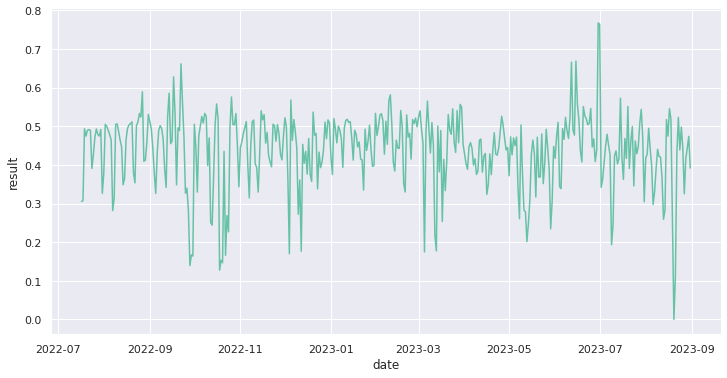

In [60]:
sns.lineplot(data=action_train.groupby(['date'])['result'].mean().reset_index(), x='date', y='result')


<AxesSubplot:xlabel='date', ylabel='result'>

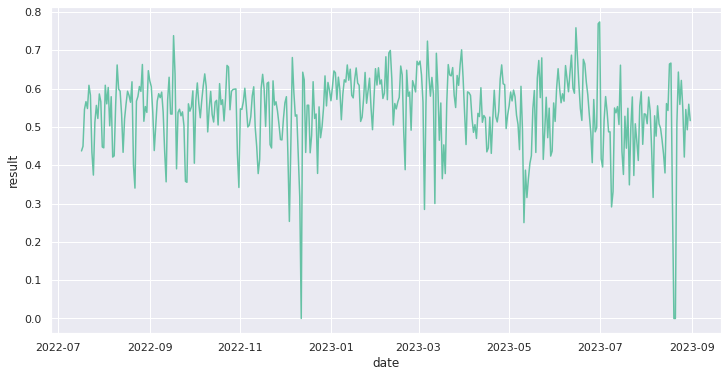

In [63]:
sns.lineplot(data=test.groupby(['date'])['result'].mean().reset_index(), x='date', y='result')

# Итог

Сравнивая полученное распределение визуально можем прийти к выводу, что наш алгоритм отработал хорошо. 